<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Paul%20Himyak/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import re
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import concatenate, Embedding, Conv1D, Input, Dense, Dropout, BatchNormalization, Flatten , SpatialDropout1D, Reshape, RepeatVector, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
from tensorflow.keras import utils


import gdown

In [163]:
dataset_url = "https://drive.google.com/uc?export=download&id=1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg"
#dataset_url = "https://docs.google.com/spreadsheets/d/1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg/edit?usp=share_link&ouid=113369956649761615778&rtpof=true&sd=true"
dataset_filename = "profpatolog_modified.xlsx"
#!wget -qc dataset_url -O dataset_filename
gdown.download(dataset_url, output=dataset_filename, quiet=True )


'profpatolog_modified.xlsx'

In [164]:
df = pd.read_excel("profpatolog_modified.xlsx")


In [165]:
#Удаляем случайные вбросы
df.drop([843, 851, 1022, 1024], inplace = True)

#Убираем пустые колонки
empty_columns = df.columns[df.isna().all()]
df.drop(empty_columns, inplace = True, axis = 1)

In [166]:
del df['Unnamed: 0']

In [167]:
FIELD_CLIENT_AGE = "КлиентВозраст"
FIELD_CLIENT_BIRTH_DAY = "КлиентДатаРождения"
FIELD_CLIENT_GENDER = "КлиентПол"
FIELD_CLIENT_GENDER_M = 0
FIELD_CLIENT_GENDER_F = 1
FIELD_CONCLUSION = "ЗаключениеМК"
FIELD_CONCLUSION_FIT = 1
FIELD_CONCLUSION_PART_FIT = 2
FIELD_CONCLUSION_NOT_FIT = 0

FIELD_DISPANSARY_GROUP = "ДиспансернаяГруппа"
FIELD_DISPANSARY_GROUP_I = 0
FIELD_DISPANSARY_GROUP_II = 1
FIELD_DISPANSARY_GROUP_III = 2
FIELD_DISPANSARY_GROUP_OTHER = 3

FIELD_HARMFUL_FACTORS = "ВредныеФакторы"


FIELD_NEW_AGE_CATEGORY = "ВозрастКатегория"
FIELD_NEW_MKBS = "mkbs"

FIELD_CLIENT_PROFESSION = "Профессия"

In [168]:
from datetime import datetime
class MyUtils:
  conclusion_map = {FIELD_CONCLUSION_FIT:'Годен', FIELD_CONCLUSION_PART_FIT:"Частично годен", FIELD_CONCLUSION_NOT_FIT: 'Негоден'}
  @staticmethod
  def resolve_conclusion_map(x):
    return MyUtils.conclusion_map[x]
  @staticmethod  
  # Определяем функцию для расчета возраста на основе даты
  def resolve_birthdate_to_age(date):
    current_year = pd.Timestamp.now().year
    age = current_year - date.year
    return age
  def resolve_genger(x):
    if x == 'Мужской':
        return FIELD_CLIENT_GENDER_M
    elif x == 'Женский':
        return FIELD_CLIENT_GENDER_F
    else:
        return None

  def resolve_conclusion_binary(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_conclusion(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      elif "Негоден" in arg:
        return FIELD_CONCLUSION_NOT_FIT
      elif "Годен" in arg:
        return FIELD_CONCLUSION_PART_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_dispansary_group(arg):
    try:
      if arg == "I":
        return FIELD_DISPANSARY_GROUP_I
      elif arg == "II":
        return FIELD_DISPANSARY_GROUP_II
      elif "III" in arg :
        return FIELD_DISPANSARY_GROUP_III
      else:
        return FIELD_DISPANSARY_GROUP_OTHER
    except (TypeError):
        return None
  def resolve_age_to_category(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [169]:
# Преобразование колонки возраста в цифровой вид
df[FIELD_CLIENT_AGE] = df[FIELD_CLIENT_BIRTH_DAY].apply(MyUtils.resolve_birthdate_to_age)

In [170]:
# разделение возраста на категории
df[FIELD_NEW_AGE_CATEGORY] = df[FIELD_CLIENT_AGE].apply(MyUtils.resolve_age_to_category)

In [171]:
# Пол в цифру
df[FIELD_CLIENT_GENDER] = df[FIELD_CLIENT_GENDER].apply(lambda x: MyUtils.resolve_genger(x) if pd.notnull(x) else x)

In [172]:
# Удалим неиспользованные колонки
del df[FIELD_CLIENT_BIRTH_DAY]
del  df[FIELD_CLIENT_AGE]

In [173]:
#Преобразование диспансерных групп в цифру
df[FIELD_DISPANSARY_GROUP] = df[FIELD_DISPANSARY_GROUP].apply(MyUtils.resolve_dispansary_group)

In [174]:
# Преобразование заключения в цифру
df[FIELD_CONCLUSION] = df[FIELD_CONCLUSION].apply(lambda x: MyUtils.resolve_conclusion(x))

In [176]:
# Все колонки МКБ10
mkb_columns = df.filter(regex="(?i)МКБ10").columns


In [177]:
#Решил заменить пустые колонки на Z00.0
df[mkb_columns] = df[mkb_columns].fillna(value='Z00.0')

In [178]:
# объединяем значения из нескольких столбцов в одну колонку, удаляем дубликаты, чтоб уменьшить разреженность 
#df['mkb'] = df.apply(lambda row: list(set([row[mkb_col_name] for mkb_col_name in mkb_columns if not pd.isna(row[mkb_col_name]) ])), axis=1)
df[FIELD_NEW_MKBS] = df.apply(lambda row: list(set([row[mkb_col_name] for mkb_col_name in mkb_columns])), axis=1)


In [179]:

# исключаем из фрейма все МКБ поскольку теперь у нас есть одна общая mkbs
df = df.loc[:, ~df.columns.str.contains('мкб10', case=False)]


In [180]:
# разделяем факторы по одному значению
df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")

<ipython-input-180-593652ce6884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")


In [181]:
df.dropna(inplace = True)

<ipython-input-181-d1ada024d2eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


Подготавливаю все однозначные цифровые данные в OHE

In [182]:
# Объединяю категориальные значения в OHE
df_ohe = pd.get_dummies(df[[FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY]],  columns = [FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY] )

In [183]:
xTrain0 = df_ohe.values

In [184]:
xTrain0.shape

(1562, 16)

In [239]:
df[FIELD_CONCLUSION].value_counts()

0.0    1428
2.0     134
Name: ЗаключениеМК, dtype: int64

In [230]:
yTrain =  pd.get_dummies(df[FIELD_CONCLUSION]).values

In [238]:
Y_CLASSES = yTrain.shape[1]
Y_CLASSES

2

In [186]:
yTrain.shape

(1562, 2)

In [187]:
df

,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Профессия,ВозрастКатегория,mkbs
0,1,0.0,0.0,[11.4],Ведущий специалист по организации обуения,6,[Z00.0]
1,0,0.0,2.0,[4.2.5],Ведущий специалист,4,"[I11.9, Z00.0]"
2,0,2.0,1.0,[4.2.5],Главный менеджер,5,"[H52.1, Z00.0]"
3,0,0.0,0.0,[11.1],Главный специалист,4,[Z00.0]
4,0,2.0,1.0,[11.1],Старший специалист,5,"[H52.2, Z00.0]"
...,...,...,...,...,...,...,...
1960,0,0.0,1.0,"[4.4, 4.5, 6.1]",Инженер,4,"[H52.1, Z00.0]"
1961,0,0.0,0.0,"[4.4, 4.5, 6.1]",Инженер,3,[Z00.0]
1962,0,0.0,0.0,[4.4],Начальник лаборатории,4,[Z00.0]
1972,0,0.0,0.0,[3.1.8.2],"Инженер по бурению 1 категории, непосредственн...",4,[Z00.0]


Поскольку теперь mkb колонка одна, то пришла мысль поработать с ней как эмбедингом

In [188]:
df[FIELD_NEW_MKBS].explode().unique()

array(['Z00.0', 'I11.9', 'H52.1', 'H52.2', 'H53.0', 'K29.3', 'I70',
       'H90.5', 'G90.9', 'H52.0', 'S68.2', 'N60.2', 'E11.9', 'K29.6',
       'M42.1', 'D25', 'I69.4', 'N83.2', 'H90.3', 'K44.9', 'N80.0',
       'G99.0', 'G12.1', 'K81.9', 'H11.0', 'G25.0', 'K26.9', 'K86.1',
       'H91.1', 'I67.2', 'H74.1', 'N28.1', 'I83.9', 'L40.0', 'H93.0',
       'D25.9', 'I25.8', 'K80.5', 'F06.6', 'K40.9', 'E11.8', 'E10.9',
       'T94.0', 'F10.7', 'D35.2', 'L20.8', 'K29.5', 'H50.9', 'K80.2',
       'I25.2', 'Q12.0', 'S51.9', 'F06.7', 'H25.0', 'I67.9', 'I66.9',
       'K29.8', 'T90.4', 'H40.1', 'H90.4', 'F41.0', 'R25.1', 'K29.7',
       'H47.2', 'J33.0', 'H66.1', 'K26.7', 'H02.4', 'I49.9', 'H01.0',
       'F98.5', 'I49.8', 'J45.8', 'H35.0', 'H17.1', 'J30.1', 'F07.0',
       'G58.9', 'J37.0', 'H25.1', 'I25.9', 'K82.9', 'J45.9', 'G90.8',
       'K29.4'], dtype=object)

In [189]:
tokenizer_mkb = Tokenizer()
tokenizer_mkb.fit_on_texts(np.array(df[FIELD_NEW_MKBS]))
mkb_vocab_size = len(tokenizer_mkb.word_index) + 1


In [190]:
xMkbIndexed = tokenizer_mkb.texts_to_sequences(df[FIELD_NEW_MKBS])

In [191]:
mkb_max_len = max(len(sublist) for sublist in xMkbIndexed)
#mkb_max_len = max(xMkbIndexed, key=len)
print(mkb_max_len)

5


In [192]:
xMkbIndexedPadded = pad_sequences(xMkbIndexed, maxlen=mkb_max_len, padding='post')
xTrainMkb = xMkbIndexedPadded

In [193]:
xMkbIndexedPadded.shape

(1562, 5)

вредные факторы тоже токенизировал для дальнейшего использования его в эмбединге

In [194]:
tokenizer_harmfull = Tokenizer()

In [195]:
tokenizer_harmfull.fit_on_texts(df[FIELD_HARMFUL_FACTORS])


In [196]:
harmfull_vocab_size = len(tokenizer_harmfull.word_index) + 1


In [197]:
xTrainHarmfulIndexes = tokenizer_harmfull.texts_to_sequences(df[FIELD_HARMFUL_FACTORS])

In [198]:
harm_max_len = max(len(sublist) for sublist in xTrainHarmfulIndexes)


In [199]:
xTrainHarmfulIndexesPadded = pad_sequences(xTrainHarmfulIndexes, maxlen=harm_max_len, padding='post')
xTrainHarmFull = xTrainHarmfulIndexesPadded

In [200]:
xTrainHarmFull.shape

(1562, 13)

Профессии токенизировал тоже будут эмбеддингами

In [201]:
maxWordsCount = 1000 
tokenizer_prof = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_prof.fit_on_texts(df[FIELD_CLIENT_PROFESSION]) 


In [202]:
prof_vocab_size = len(tokenizer_prof.word_index) + 1
prof_vocab_size


514

In [203]:
xTrainProfIndexed = tokenizer_prof.texts_to_sequences(df[FIELD_CLIENT_PROFESSION])

In [204]:
prof_max_len = max(len(sublist) for sublist in xTrainProfIndexed)


In [205]:
xTrainProfIndexedPadded = pad_sequences(xTrainProfIndexed, maxlen=prof_max_len, padding='post')
xTrainProf = xTrainProfIndexedPadded

In [206]:
xTrainProf.shape

(1562, 12)

In [207]:
x_train, x_test, x_train_mkb, x_test_mkb, x_train_harmfull, x_test_harmfull, x_train_prof, x_test_prof,  y_train, y_test = train_test_split(xTrain0,
                                                                                                              xTrainMkb,
                                                                                                              xTrainHarmFull,
                                                                                                              xTrainProf,                                                                                                              
                                                                                                              yTrain, 
                                                                                                              test_size=0.2,
                                                                                                              shuffle = False)

In [208]:
# На этот вход подаются все OHE
input0 = Input((x_train.shape[1],))
# Сюда подаются mkb в виде последовательности токенов , поскольку они уже объединины в одой колонке
input_mkb = Input((x_train_mkb.shape[1],))
# Сюда подаются вредные факторы тоже аналогично мкб , как будто это предложение из токенов 
input_harmfull = Input((x_train_harmfull.shape[1],))
# Сюда подаются профессии , тоже как предложение токенов
input_prof = Input((x_train_prof.shape[1],))

In [209]:
x_train_mkb[:3,:]

array([[1, 0, 0, 0, 0],
       [2, 1, 0, 0, 0],
       [3, 1, 0, 0, 0]], dtype=int32)

In [210]:
def create_model1(input0, input_mkb, input_harmfull, input_prof):
  x0 = BatchNormalization()(input0)
  x0 = Dense(1024, activation='relu') (x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(768, activation='sigmoid')(x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(512, activation='sigmoid')(x0)

  x1 = Embedding(mkb_vocab_size, 10, input_length = mkb_max_len)(input_mkb)
  x1 = SpatialDropout1D(0.2)(x1)
  x1 = Dense(100, activation = 'sigmoid')(x1)
  #x1 = Flatten()(x1)

  x2 = Embedding(harmfull_vocab_size, 10, input_length = harm_max_len)(input_harmfull)
  x2 = SpatialDropout1D(0.2)(x2)
  x2 = Dense(100, activation = 'sigmoid')(x2)
  #x2 = Flatten()(x2)

  x3 = Embedding(prof_vocab_size, 10, input_length = prof_max_len)(input_prof)
  x3 = SpatialDropout1D(0.2)(x3)
  x3 = Dense(100, activation = 'sigmoid')(x3)
  #x3 = Flatten()(x3)

  x_ = concatenate([x1, x2, x3], axis = -2)
  x_ = Flatten()(x_)
  x = concatenate([x0, x_])


  x = Dense(800, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(Y_CLASSES, activation='softmax')(x)

  return Model((input0, input_mkb, input_harmfull, input_prof), x )


Модель 1

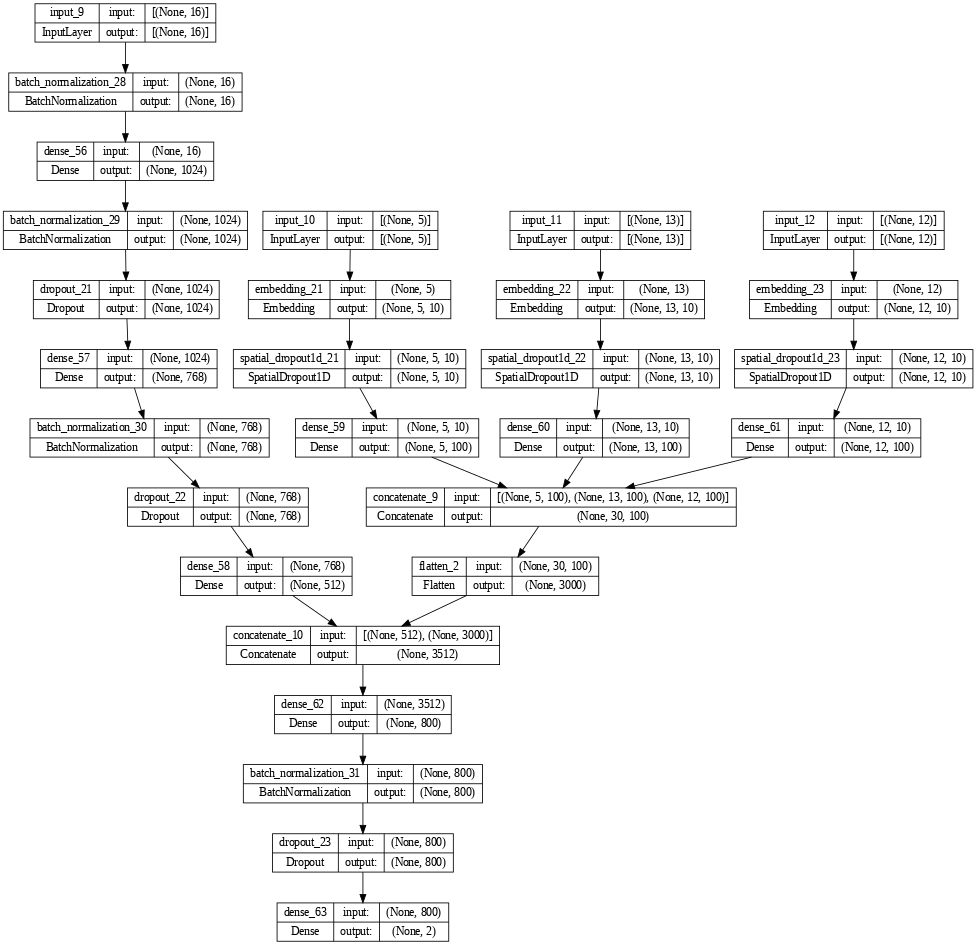

In [213]:
model1 = create_model1(input0, input_mkb, input_harmfull, input_prof)
utils.plot_model(model1, dpi=60, show_shapes = True)


In [214]:
model1.compile(optimizer = Adam(learning_rate = 1e-5), loss = keras_losses.categorical_crossentropy, metrics=['mae', 'accuracy'])

In [215]:

# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [216]:
history = model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
                    y_train,
                    batch_size=32,
                    epochs = 10,
                    validation_split = 0.2,
                    verbose = 1)

Epoch 1/10
32/32 [==============================] - 8s 139ms/step - loss: 0.8788 - mae: 0.4766 - accuracy: 0.5245 - val_loss: 0.6719 - val_mae: 0.4892 - val_accuracy: 0.9000
Epoch 2/10
32/32 [==============================] - 4s 119ms/step - loss: 0.8870 - mae: 0.4777 - accuracy: 0.5425 - val_loss: 0.5863 - val_mae: 0.4417 - val_accuracy: 0.9000
Epoch 3/10
32/32 [==============================] - 4s 117ms/step - loss: 0.8699 - mae: 0.4854 - accuracy: 0.5185 - val_loss: 0.5326 - val_mae: 0.4079 - val_accuracy: 0.9000
Epoch 4/10
32/32 [==============================] - 3s 87ms/step - loss: 0.8349 - mae: 0.4731 - accuracy: 0.5445 - val_loss: 0.6125 - val_mae: 0.4570 - val_accuracy: 0.9000
Epoch 5/10
32/32 [==============================] - 3s 93ms/step - loss: 0.8229 - mae: 0.4702 - accuracy: 0.5666 - val_loss: 0.6390 - val_mae: 0.4718 - val_accuracy: 0.9000
Epoch 6/10
32/32 [==============================] - 3s 90ms/step - loss: 0.8020 - mae: 0.4661 - accuracy: 0.5495 - val_loss: 0.6323 

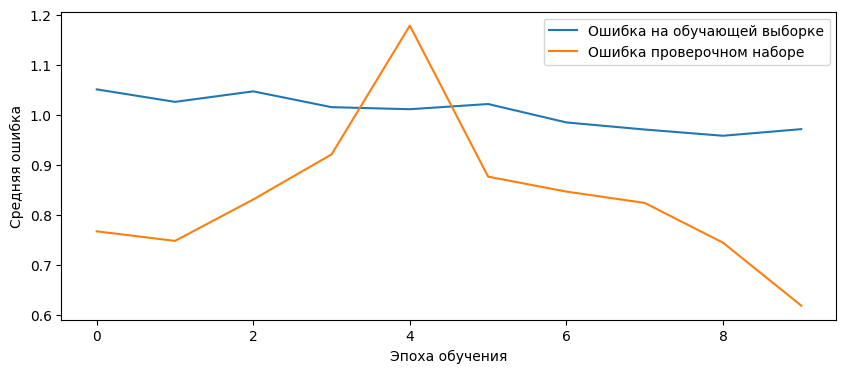

In [138]:
compare_sharp_loss(history, 10, 4)

Модель 2

In [217]:
x0 = BatchNormalization()(input0)
x0 = Dense(1024, activation='relu') (x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(768, activation='sigmoid')(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(512, activation='sigmoid')(x0)

x1 = Embedding(mkb_vocab_size, 10, input_length = mkb_max_len)(input_mkb)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Conv1D(50,3, activation = 'relu', padding='same')(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dense(100, activation = 'relu')(x1)
#x1 = Flatten()(x1)

x2 = Embedding(harmfull_vocab_size, 10, input_length = harm_max_len)(input_harmfull)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Conv1D(50,2, activation = 'relu', padding='same')(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dense(100, activation = 'relu')(x2)
#x2 = Flatten()(x2)

x3 = Embedding(prof_vocab_size, 10, input_length = prof_max_len)(input_prof)
x3 = SpatialDropout1D(0.2)(x3)
x3 = Conv1D(50,2, activation = 'relu', padding='same')(x3)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dense(100, activation = 'relu')(x3)
#x3 = Flatten()(x3)

#x_ = concatenate([x1, x2, x3], axis = -2)
#x_ = Flatten()(x_)
x = concatenate([x0, x1, x2, x3])


x = Dense(800, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(Y_CLASSES, activation='softmax')(x)

model2 =  Model((input0, input_mkb, input_harmfull, input_prof), x )
model2.compile(optimizer = Adam(learning_rate = 1e-53), loss = keras_losses.mse, metrics=[keras_metrics.mae])


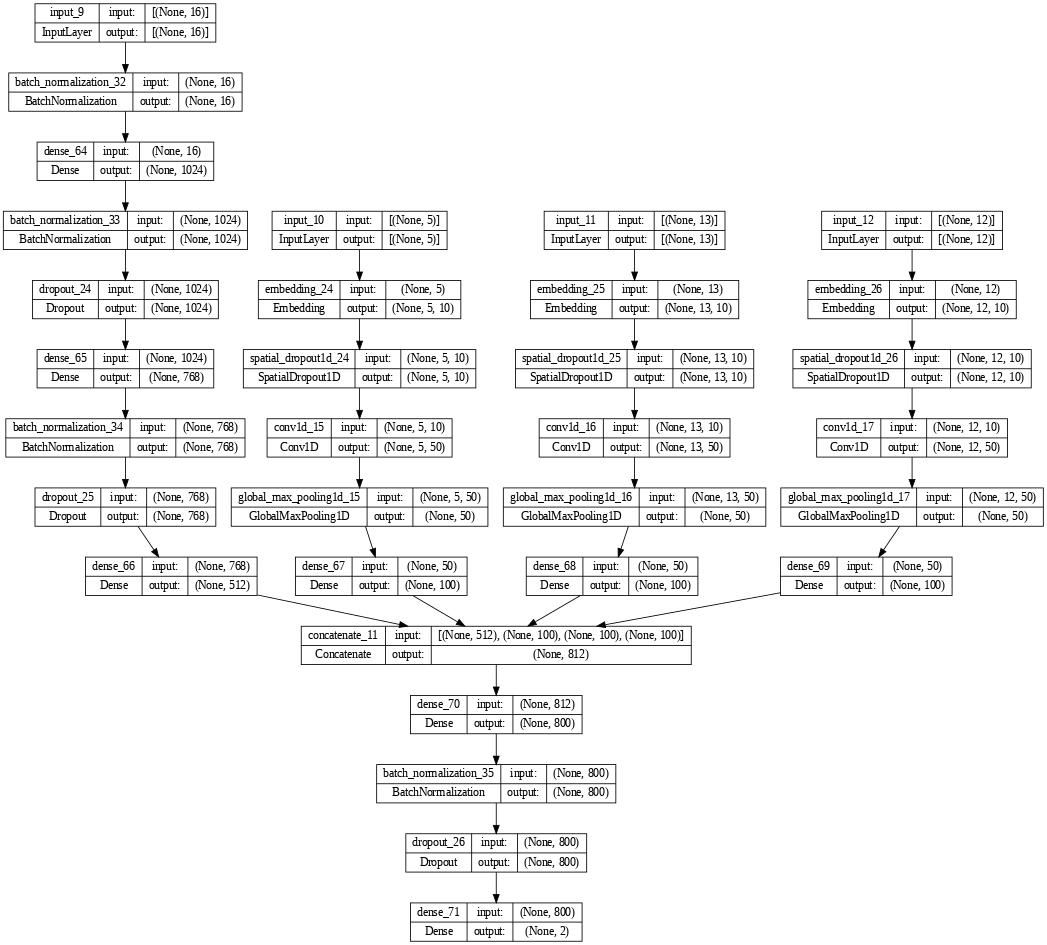

In [218]:
utils.plot_model(model2, dpi=60, show_shapes = True)


In [219]:
print(x_train.shape,x_train_mkb.shape, x_train_harmfull.shape, x_train_prof.shape)

(1249, 16) (1249, 5) (1249, 13) (1249, 12)


In [221]:
history = model2.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
                    y_train,
                    batch_size=32,
                    epochs = 50,
                    validation_split = 0.20,
                    verbose = 1)

Epoch 1/50
32/32 [==============================] - 1s 45ms/step - loss: 0.3495 - mean_absolute_error: 0.4994 - val_loss: 0.2137 - val_mean_absolute_error: 0.4479
Epoch 2/50
32/32 [==============================] - 1s 45ms/step - loss: 0.3411 - mean_absolute_error: 0.4980 - val_loss: 0.2227 - val_mean_absolute_error: 0.4519
Epoch 3/50
32/32 [==============================] - 1s 46ms/step - loss: 0.3645 - mean_absolute_error: 0.5165 - val_loss: 0.2299 - val_mean_absolute_error: 0.4530
Epoch 4/50
32/32 [==============================] - 2s 66ms/step - loss: 0.3546 - mean_absolute_error: 0.5121 - val_loss: 0.2355 - val_mean_absolute_error: 0.4525
Epoch 5/50
32/32 [==============================] - 2s 68ms/step - loss: 0.3466 - mean_absolute_error: 0.5017 - val_loss: 0.2401 - val_mean_absolute_error: 0.4510
Epoch 6/50
32/32 [==============================] - 2s 50ms/step - loss: 0.3523 - mean_absolute_error: 0.5090 - val_loss: 0.2458 - val_mean_absolute_error: 0.4517
Epoch 7/50
32/32 [====

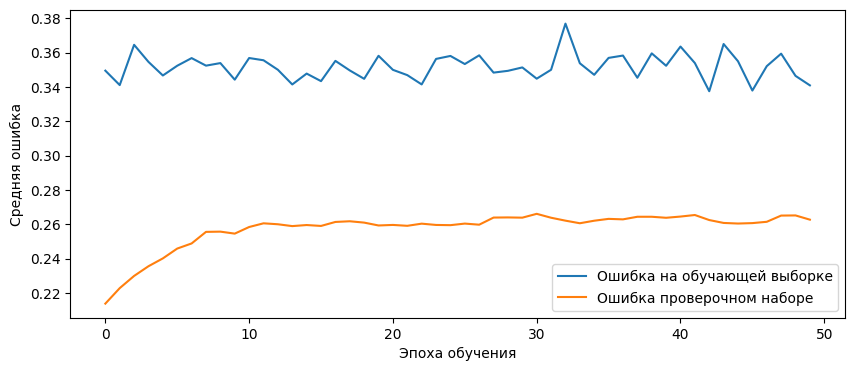

In [222]:
compare_sharp_loss(history, 10, 4)

In [ ]:
y_pred = model2.predict((x_test, x_test_mkb, x_test_harmfull, x_test_prof))
y_pred_idx = np.argmax(y_pred, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
df_result = pd.DataFrame({'pred': y_pred_idx, 'test': y_test_idx})
df_result['pred'] = df_result['pred'].apply(MyUtils.resolve_conclusion_map)
df_result['test'] = df_result['test'].apply(MyUtils.resolve_conclusion_map)
display(df_result)
num_wrong = 0
for pred, test in zip(y_pred_idx, y_test_idx):
    if pred != test:
        num_wrong += 1

percent_wrong = num_wrong / len(y_test_idx) * 100
print(f"Percent wrong: {percent_wrong:.2f}%")


10/10 [==============================] - 0s 13ms/step


,pred,test
0,Годен,Годен
1,Годен,Годен
2,Годен,Годен
3,Годен,Годен
4,Годен,Годен
...,...,...
308,Негоден,Годен
309,Годен,Годен
310,Годен,Годен
311,Годен,Годен


Percent wrong: 17.89%


**Вывод**: Основная идея объединить МКБ в одну колонку и пройти по ней как по предложению через свертки, для выявления взаимосвязи между специалистами.

Результат слабоватый, возможно из-за слишком несбалансированнной базы
По этой же причине не стал обрабатывать основные текстовые поля, хотя была та же идея избавится от разрежения значений полей специалистов путём объединения текстов колонок в одну в виде текста с разбивкой на абзацы и заголовками  для каждого специалиста.
Если будет база со сбалансированными данными, возможно это будет уместно сделать 